In [1]:
using Combinatorics
using LinearAlgebra
using LaTeXStrings
using Chaos
using Statistics
using CSV
using DataFrames
using GLMakie
using SpecialFunctions
#using LsqFit

┌ Info: Precompiling Chaos [0aea4425-8685-4cf8-ab93-d00eaca7e4b3]
└ @ Base loading.jl:1423
┌ Warning: Package Chaos does not have LinearAlgebra in its dependencies:
│ - If you have Chaos checked out for development and have
│   added LinearAlgebra as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Chaos
└ Loading LinearAlgebra into Chaos from project dependency, future warnings for Chaos are suppressed.


In [326]:
Na = 120; # number of atoms
Ls = 3; # number of wells

### The particle conserved basis

In [327]:
Hbs = integer_partition(N=Na, L=Ls);

In [328]:
Lb = length(Hbs) # the dimension of the Hilbert space

7381

In [329]:
Lb_shouldbe = binomial(Na+Ls-1, Na)

7381

### The hopping Hamiltonian

In [330]:
HLs = zeros(Float64, Lb, Lb)
for i in 1:Ls-1
    HLs += hopping_pair(m=i, Na=Na, Hbs=Hbs)
end

In [331]:
Hhop = HLs + HLs';

### The onsite interaction

In [332]:
Honsite = zeros(Float64, Lb, Lb);

In [333]:
for j in 1:Lb
    for k in 1:Lb
        if j == k
            sum = 0
            for l in 1:Ls
                sum += Hbs[j][l]^2 - Hbs[j][l]
            end
            Honsite[j,k] += sum
        end
    end
end

### The tilt potential

In [334]:
function Htit(γ::Float64)
    Htit = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    Htit[j,k] += -(l-(Ls+1)/2)*γ*Hbs[j][l]
                end
            end

        end
    end
    return Htit
end

Htit (generic function with 1 method)

### Soft-core interactions

In [335]:
Λ(delta::Int64, d::Float64, C6::Float64, R::Float64) = C6 / ((delta)^6*d^6 + R^6)

Λ (generic function with 1 method)

In [336]:
# Here 'd' is the lattice constant.
function Hsc(d::Float64, C6::Float64, R::Float64)
    Hsc = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    for m in 1:Ls
                        if l-m == 0
                            Hsc[j,k] += 2*Λ(0,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 1
                            Hsc[j,k] += Λ(1,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 2
                            Hsc[j,k] += Λ(2,d,C6,R)*Hbs[j][l]*Hbs[j][m]
                        else
                            continue
                        end
                    end
                end
            end
        end
    end
    return Hsc
end

Hsc (generic function with 1 method)

In [337]:
function Hsc_new(;Λ::Float64)
    Hsc = zeros(Float64, Lb, Lb)
    for j in 1:Lb
        for k in 1:Lb
            if j == k
                for l in 1:Ls
                    for m in 1:Ls
                        if l-m == 0
                            Hsc[j,k] += 0
                        elseif abs(m-l) == 1
                            Hsc[j,k] += Λ*Hbs[j][l]*Hbs[j][m]
                        elseif abs(m-l) == 2
                            Hsc[j,k] += Λ/2*Hbs[j][l]*Hbs[j][m]
                        else
                            continue
                        end
                    end
                end
            end
        end
    end
    return Hsc
end

Hsc_new (generic function with 1 method)

### Construction of the full Hamiltonian

In [338]:
function Htot(;γ::Float64, J::Float64, g::Float64, d::Float64, C6::Float64, R::Float64)
    Htot = Htit(γ) - J*Hhop + (g/2)*Honsite + (1/2)*Hsc(d,C6,R)
    return Htot
end

Htot (generic function with 1 method)

In [339]:
function Htot_new(;γ::Float64, J::Float64, g::Float64, Λ::Float64)
    Htot = Htit(γ) - J*Hhop + (g/2)*Honsite + (1/(2*Na))*Hsc_new(Λ=Λ)
    return Htot
end

Htot_new (generic function with 1 method)

### Fitting the edge of the distribution

In [272]:
# This function is for plotting the level statistics.
function get_diffs(;v::Int64, γ::Float64, J::Float64, g::Float64, Λ::Float64)
    eigs = eigvals(Htot_new(γ=γ, J=J, g=g, Λ=Λ));
    diffs = [eigs[i+1]-eigs[i] for i in 1:length(eigs)-1];
    index1 = Int((v-1)/2)
    index2 = length(diffs)-index1
    diffs_dropped = diffs[index1:index2];
    
    new_diffs = Float64[]
    for i in 1:length(diffs_dropped)
        drop_index = Int((v-1)/2)
        if i-drop_index>0 && i+drop_index<=length(diffs_dropped)
            append!(new_diffs, diffs_dropped[i]/average_spacing(diffs_dropped, i, v))
        end
    end
    return diffs_dropped, new_diffs
end

get_diffs (generic function with 1 method)

In [273]:
function get_diffs_new(;v::Int64, step::Int64, γ::Float64, J::Float64, g::Float64, Λ::Float64)
    eigs = eigvals(Htot_new(γ=γ, J=J, g=g, Λ=Λ));
    diffs = [eigs[i+1]-eigs[i] for i in 1:length(eigs)-1];
    index1 = Int((v-1)/2)
    index2 = length(diffs)-index1
    diffs_dropped = diffs[index1:index2];
    
    new_diffs = Float64[]
    for i in 1:length(diffs_dropped)
        drop_index = Int((step-1)/2)
        if i-drop_index>0 && i+drop_index<=length(diffs_dropped)
            append!(new_diffs, diffs_dropped[i]/average_spacing(diffs_dropped, i, step))
        end
    end
    return diffs_dropped, new_diffs
end

get_diffs_new (generic function with 1 method)

In [274]:
# Manually generate the historgram bins.
# This function is prepared for later fittings.
function fit_edge(;dmin::Float64, dmax::Float64, bin::Float64, diffs::Vector{Float64}, new_diffs::Vector{Float64})
    dmin = dmin;
    dmax = dmax;
    bin = bin # the width of the bin
    Nbin = Int(floor((dmax-dmin)/bin))
    Ndstep = Int(floor(length(diffs)/v));

    xbin = [bin*(i-1) for i in 1:Nbin];
    Nenergy = vec(zeros(Float64, Nbin, 1));

    for i in 1:length(new_diffs)
        for j in 1:Nbin
            if xbin[j] <= new_diffs[i] < xbin[j+1]
                Nenergy[j] += 1
            end
        end
    end

    normNenergy = Nenergy/(bin*sum(Nenergy))
    return xbin, normNenergy
end

fit_edge (generic function with 1 method)

### Distributions of energy eigenvalues

In [353]:
H1 = Htot_new(γ=2.5, J=1.0, g=0.0, Λ=7.0)
eigs1 = eigvals(H1)/Na;
#hist(eigs1, bins=40)

In [354]:
open("./new_data/DOS/lambda=7/lambda.txt", "w") do io
    for i in eigs1
        println(io, i)
    end
end

### Level statistics

In [306]:
# In our case, we take average every 5 levels, we drop (v-1)/2 spacings at either end.
#v = 1801;
v = 5
# This is defined for later convenience.
f(x) = exp(-x);
ff(x) = (π*x/2)*exp(-π*x^2/4);

In [319]:
diffs1_dropped, new_diffs1 = get_diffs(v=v, γ=2.5, J=1.0, g=0.0, Λ=7.0);
#diffs1_dropped, new_diffs1 = get_diffs_new(v=v, step=5, γ=2.5, J=1.0, g=0.0, Λ=8.0);

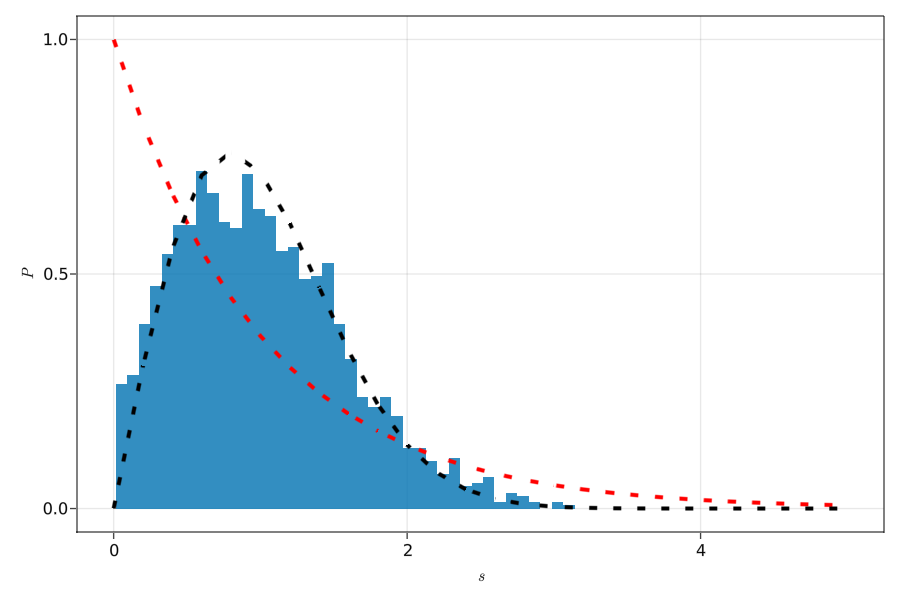

In [320]:
p2 = Figure(resolution=(900,600))
ax2 = Axis(p2[1,1], xlabel=L"$s$", ylabel=L"$P$")
xs = 0:0.2:5;
ys = f.(xs)
ys2 = ff.(xs)
hist!(ax2, new_diffs1,bins=40, normalization=:pdf)
lines!(ax2, xs, ys, linestyle=:dot, linewidth=4, color=:red)
lines!(ax2, xs, ys2, linestyle=:dot, linewidth=4, color=:black)
p2

In [207]:
xbins, normNenergy = fit_edge(;dmin=0.0, dmax=4.0, bin=0.1, diffs=diffs1_dropped, new_diffs=new_diffs1)

hists = Tuple{Float64, Float64}[]
for i in 1:length(xbins)-1
    push!(hists, (xbins[i],normNenergy[i]))
    push!(hists, (xbins[i+1],normNenergy[i]))
end

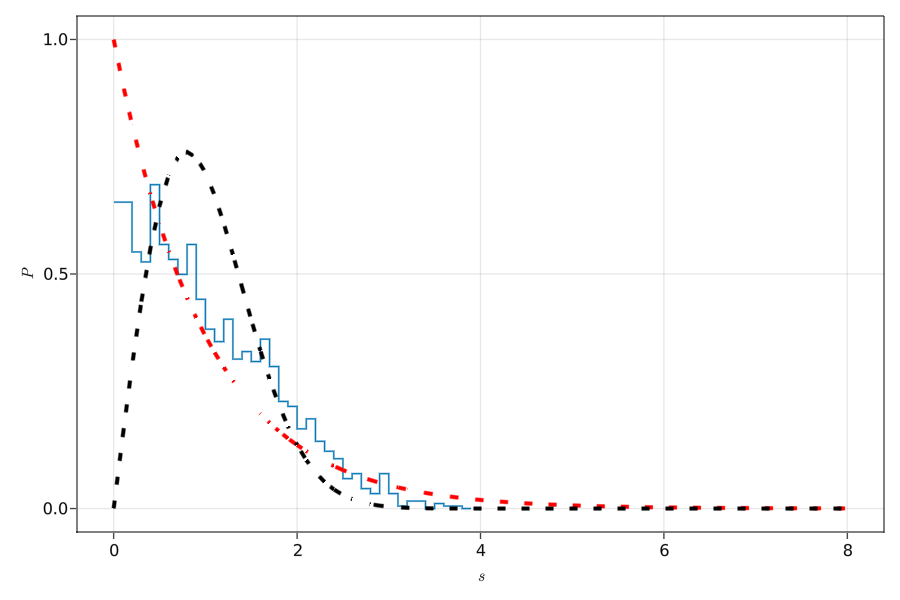

In [208]:
p3 = Figure(resolution=(900,600))
ax3 = Axis(p3[1,1], xlabel=L"$s$", ylabel=L"$P$")
scatterlines!(ax3, hists, markersize=0.0)
xs = 0:0.1:8;
ys = f.(xs)
ys2 = ff.(xs)
#hist!(ax3, new_diffs1,bins=40, normalization=:pdf)
lines!(ax3, xs, ys, linestyle=:dot, linewidth=4, color=:red)
lines!(ax3, xs, ys2, linestyle=:dot, linewidth=4, color=:black)
p3

### Brody distribution

In [74]:
# Due to the fact that there is no stable package of nonlinear fitting in Julia,
# I can only save the data to python to find the chaos indicator.

# Case 1: Fixing γ at 2.5. Scanning through Λ
for Λ in 2.0:0.05:15.0
    diffs_dropped, new_diffs = get_diffs(v=v, γ=2.5, J=1.0, g=0.0, Λ=Λ);
    xbin, normNenergy = fit_edge(dmin=1.0, dmax=8.0, bin=0.1, diffs=diffs_dropped, new_diffs=new_diffs)
    open("./new_data/gamma=2.5/N=60/Lambda=$Λ.txt", "w") do io 
        for i in normNenergy
            println(io, i)
        end
    end
end

In [29]:
# Case 2: Fixing Λ. Scanning through γ.
for γ in 0.0:0.05:7.0
    diffs_dropped, new_diffs = get_diffs_new(v=v, step=5, γ=γ, J=1.0, g=0.0, Λ=8.0)
    xbin, normNenergy = fit_edge(dmin=0.0, dmax=8.0, bin=0.1, diffs=diffs_dropped, new_diffs=new_diffs)
    open("./new_data/Lambda=8.0/N=60/gamma=$γ.txt", "w") do io
        for i in normNenergy
            println(io, i)
        end
    end
end

### Plots

In [21]:
J = 1.0;
g = 0.0;
γs = 0.0:0.1:5.0;
Λs = -1.0:0.01:1.0
Λs_new = 0.0:0.1:15.0

0.0:0.1:15.0

In [22]:
for Λ in Λs_new
    diffs_dropped, new_diffs = get_diffs(v=v, γ=0.5, J=1.0, g=0.0, Λ=Λ);
    p = Figure(resolution=(900,600))
    ax = Axis(p[1,1], xlabel=L"$s$", ylabel=L"$P$")
    ax.title = "Λ=$Λ"
    xs = 0:0.2:8;
    ys = f.(xs)
    ys2 = ff.(xs)
    hist!(ax, new_diffs,bins=40, normalization=:pdf)
    lines!(ax, xs, ys, linestyle=:dot, linewidth=4, color=:red)
    lines!(ax, xs, ys2, linestyle=:dot, linewidth=4, color=:black)
    save("./juliapics/levelstat/N=60/gamma=0.5/Λ=$Λ.png", p)
end

In [23]:
for Λ in Λs_new
    diffs_dropped, new_diffs = get_diffs(v=v, γ=2.5, J=1.0, g=0.0, Λ=Λ);
    p = Figure(resolution=(900,600))
    ax = Axis(p[1,1], xlabel=L"$s$", ylabel=L"$P$")
    ax.title = "Λ=$Λ"
    xs = 0:0.2:8;
    ys = f.(xs)
    ys2 = ff.(xs)
    hist!(ax, new_diffs,bins=40, normalization=:pdf)
    lines!(ax, xs, ys, linestyle=:dot, linewidth=4, color=:red)
    lines!(ax, xs, ys2, linestyle=:dot, linewidth=4, color=:black)
    save("./juliapics/levelstat/N=60/gamma=2.5/Λ=$Λ.png", p)
end

### Energy levels

In [293]:
Λs_new = 0.0:0.1:15.0

0.0:0.1:15.0

In [294]:
eig_mat = zeros(Float64, Lb, length(Λs_new))
i = 1
for Λ in Λs_new
    H = Htot_new(γ=0.0, J=1.0, g=0.0, Λ=Λ)
    eigs = eigvals(H)
    eig_mat[:,i] = eigs/Na
    i += 1
end

In [295]:
p4 = Figure(resolution=(900,600))
ax4 = Axis(p4[1,1], xlabel=L"$U$", ylabel=L"$E$")
for i in 1:Lb
    lines!(ax4, Λs_new, eig_mat[i,:])
end

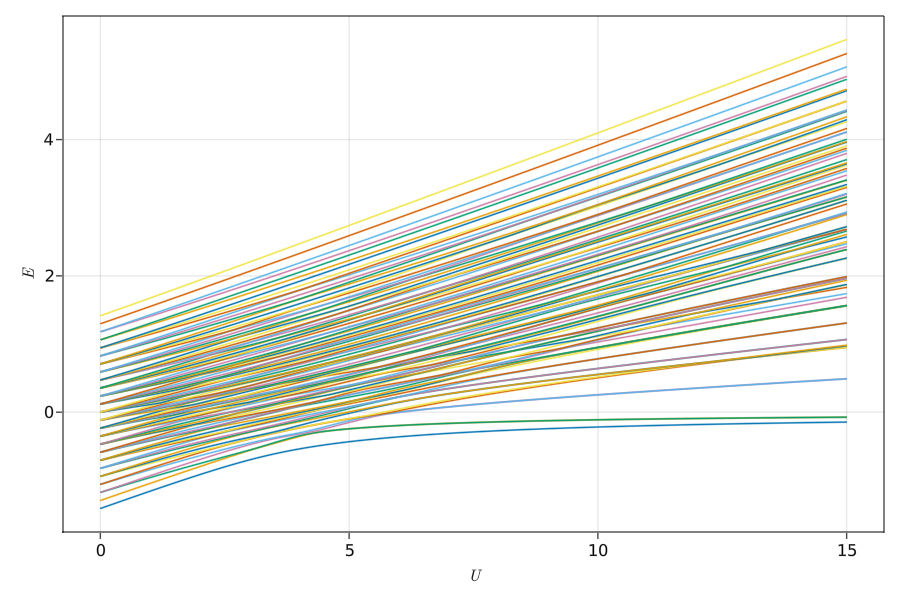

In [296]:
p4

In [62]:
# Dict1 = Dict{Float64, Vector{Vector{Float64}}}(i=>[] for i in Λs);

In [65]:
# for Λ in Λs
#     for γ in γs
#         H = Htot_new(γ=γ, J=1.0, g=g, Λ=Λ)
#         eigs = eigvals(H)
#         push!(Dict1[Λ], eigs)
#     end
# end

In [138]:
# # Plot the diagrams w.r.t γ
# fontsize_theme = Theme(fontsize = 45)
# set_theme!(fontsize_theme)

# for Λ in Λs
#     eigs = Dict1[Λ];
#     eigs_mat = zeros(Float64, length(γs), Lb);
#     for i in 1:length(γs)
#         eigs_mat[i,:] = eigs[i]
#     end
    
#     f = Figure(resolution=(1000,1000))
#     ax = Axis(f[1,1], xlabel=L"\gamma", ylabel=L"\epsilon")
#     ax.title = "Λ=$Λ"
#     for i in 1:Lb
#         lines!(ax, γs, eigs_mat[:,i])
#     end
#     save("/Users/tianyiyan/Desktop/Chaos/juliapics/spectrum_less/lambda=$Λ.png",f)
# end

LoadError: UndefVarError: Λs not defined